# MOT data analysis
This notebook will use an sqlite database file already generated by another notebook.  It will perform some SQL querying to filter and sort the data.  Then make use of pandas, numpy, matplotlib, seaborn etc to do some exploratory data analysis.  My intention is to then train some machine learning models to try to provide useful insight from the data such as trends, predicted test pass rates etc.

## Setup database access

In [1]:
# Import and create a new database file
import sqlite3
from sqlite3 import Error
import os

def create_connection(path):
    connection = None
    try:
        connection = sqlite3.connect(path)
        print("Connection to SQLite DB successful")
    except Error as e:
        print(f"The error '{e}' occurred")

    return connection

connection = create_connection(os.path.join('data','mot.sqlite'))

Connection to SQLite DB successful


In [2]:
# Create function to simply execute query
def execute_query(connection, query, firstonly=False, verbose=True):
    cursor = connection.cursor()
    try:
        cursor.execute(query)
        connection.commit()
        if verbose:print("Query executed successfully");
    except Error as e:
        print(f"The error '{e}' occurred")
    if firstonly:
        return cursor.fetchone()
    else:
        return cursor.fetchall()

In [3]:
import pandas as pd
import os

# Run some initial queries
There are 39 million entries in the  in the database! My computer won't be able to process all of that practically.  So we'll need to come up with a way to produce a meaningfully representative subset of it with less records.  Random subsampling etc is probably OK in this case, due to the scale

In [4]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(test_id) FROM mot1;''')
print(f'Total number of entries in mot1 table is: {response[0][0]}')

Query executed successfully
Total number of entries in mot1 table is: 39310698


In [5]:
pd.read_sql_query('''SELECT * 
FROM mot1 
WHERE vehicle_id IN (
    SELECT vehicle_id 
    FROM mot1 
    ORDER BY RANDOM() 
    LIMIT 10)''', connection)

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,1670545361,1196640166,2019-05-17 00:00:00,4,NT,1,42945,AL,FORD,KA,WHITE,PE,1242,2010-12-21 00:00:00
1,873705579,1196640166,2019-05-17 00:00:00,4,RT,0,42945,AL,FORD,KA,WHITE,PE,1242,2010-12-21 00:00:00
2,1443171587,41932102,2019-06-25 00:00:00,4,NT,1,30921,W,TOYOTA,RAV4,BLACK,PE,1998,2004-08-25 00:00:00
3,81847519,41932102,2019-06-25 00:00:00,4,RT,0,30921,W,TOYOTA,RAV4,BLACK,PE,1998,2004-08-25 00:00:00
4,738717539,295708560,2019-01-14 00:00:00,7,NT,0,197159,SL,FORD,TRANSIT,WHITE,DI,2397,2007-03-01 00:00:00
5,266252723,1106042946,2019-02-16 00:00:00,4,NT,1,91196,TN,MERCEDES,A 160,SILVER,PE,1598,2004-06-15 00:00:00
6,1424027599,1412836811,2019-02-18 00:00:00,4,NT,2,35751,GL,CITROEN,C3,WHITE,PE,1199,2013-03-01 00:00:00
7,429040433,1106042946,2019-02-20 00:00:00,4,RT,0,91196,TN,MERCEDES,A 160,SILVER,PE,1598,2004-06-15 00:00:00
8,1996111325,1143335217,2019-02-26 00:00:00,4,NT,1,33985,B,SEAT,IBIZA,WHITE,PE,1390,2014-03-31 00:00:00
9,1079427531,1143335217,2019-02-27 00:00:00,4,RT,0,34006,B,SEAT,IBIZA,WHITE,PE,1390,2014-03-31 00:00:00


In [11]:
pd.read_sql_query('''SELECT * 
FROM mot1 
WHERE postcode_area LIKE "G"
LIMIT 5''', connection)

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,89719943,343699759,2019-04-01 00:00:00,4,NT,0,43500,G,PEUGEOT,BOXER,WHITE,DI,2198,2014-03-20 00:00:00
1,273750413,753234121,2019-04-01 00:00:00,4,NT,0,29730,G,BMW,X1,BLACK,DI,1995,2016-03-18 00:00:00
2,839477323,1499010618,2019-04-01 00:00:00,4,NT,1,143129,G,VOLKSWAGEN,CADDY,WHITE,DI,1968,2006-09-26 00:00:00
3,1614166795,537938057,2019-04-01 00:00:00,4,RT,0,27114,G,AUDI,A5,WHITE,DI,1968,2015-09-02 00:00:00
4,707053023,191299390,2019-04-01 00:00:00,4,NT,1,197200,G,BMW,3 SERIES,BLACK,DI,1995,2006-06-19 00:00:00


In [15]:
response = execute_query(connection,'''SELECT COUNT(DISTINCT test_id) FROM mot1
WHERE postcode_area LIKE "G";''')
print(f'Total number of tests in G postcode is: {response[0][0]}')

Query executed successfully
Total number of tests in G postcode is: 631635


In [16]:
response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G";''')
print(f'Total number of unique vehicles in G postcode is: {response[0][0]}')

Query executed successfully
Total number of unique vehicles in G postcode is: 487673


**Observation**
There were 630k tests in G postcode, but only 490k unique vehicles

In [14]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G"
AND fuel_type LIKE "DI";''')
print(f'Total number of Diesel cars in G postcode is: {response[0][0]}')

Query executed successfully
Total number of Diesel cars in G postcode is: 227727


In [17]:
# Get number of rows in database
response = execute_query(connection,'''SELECT COUNT(DISTINCT vehicle_id) FROM mot1
WHERE postcode_area LIKE "G"
AND fuel_type LIKE "DI"
AND test_result = 1;''')
print(f'Total number of Diesel cars in G postcode is: {response[0][0]}')
#??? not sure about this

Query executed successfully
Total number of Diesel cars in G postcode is: 58853


## Using pandas
To work out how many passed first time in this subset`

In [19]:
df = pd.read_sql_query('''
SELECT * FROM mot1
WHERE postcode_area LIKE "G"
AND fuel_type LIKE "DI";
''', connection)
df

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,89719943,343699759,2019-04-01 00:00:00,4,NT,0,43500,G,PEUGEOT,BOXER,WHITE,DI,2198,2014-03-20 00:00:00
1,273750413,753234121,2019-04-01 00:00:00,4,NT,0,29730,G,BMW,X1,BLACK,DI,1995,2016-03-18 00:00:00
2,839477323,1499010618,2019-04-01 00:00:00,4,NT,1,143129,G,VOLKSWAGEN,CADDY,WHITE,DI,1968,2006-09-26 00:00:00
3,1614166795,537938057,2019-04-01 00:00:00,4,RT,0,27114,G,AUDI,A5,WHITE,DI,1968,2015-09-02 00:00:00
4,707053023,191299390,2019-04-01 00:00:00,4,NT,1,197200,G,BMW,3 SERIES,BLACK,DI,1995,2006-06-19 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291294,1423309299,1492615767,2019-09-30 00:00:00,4,RT,0,31857,G,VOLKSWAGEN,PASSAT,WHITE,DI,1598,2017-01-27 00:00:00
291295,1140545331,490955033,2019-09-30 00:00:00,4,NT,0,31936,G,AUDI,A4,SILVER,DI,1968,2015-08-26 00:00:00
291296,116981667,371171024,2019-09-30 00:00:00,4,NT,2,138074,G,PEUGEOT,207,BLACK,DI,1398,2007-09-05 00:00:00
291297,325745255,1455726733,2019-09-30 00:00:00,4,NT,0,25342,G,AUDI,A3,RED,DI,1598,2016-10-03 00:00:00


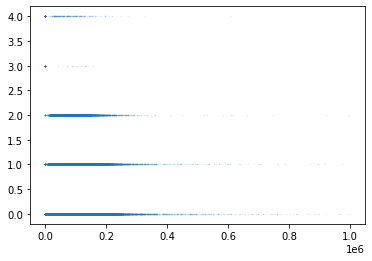

In [40]:
import matplotlib.pyplot as plt
ax1 = plt.axes();
ax1.plot(df['test_mileage'],df['test_result'],'.',markersize=1, alpha=0.1);

In [53]:
df_pass = df.copy()

print('Num rows:',len(df_pass))

df_pass = df_pass.drop(df[df['test_result'] > 2].index,axis=0)
print('Num rows:',len(df_pass),' (after dropping the rows with test aborts)')

Num rows: 291299
Num rows: 289209  (after dropping the rows with test aborts)


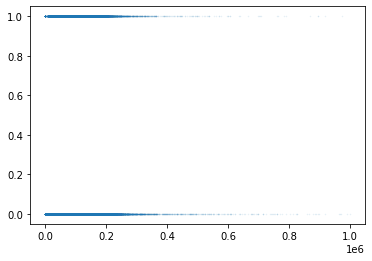

In [42]:
ax1 = plt.axes();
ax1.plot(df_pass['test_mileage'],df_pass['test_result'],'.',markersize=1, alpha=0.1);

# Other stuff

In [6]:
# Print first 5 entries
pd.read_sql_query('''SELECT * FROM mot1 LIMIT 5''', connection)

,test_id,vehicle_id,test_date,test_class_id,test_type,test_result,test_mileage,postcode_area,make,model,colour,fuel_type,cylinder_capacity,first_use_date
0,949308439,831850247,2019-04-01 00:00:00,4,NT,0,11495,LU,FORD,FIESTA,WHITE,PE,998,2016-06-06 00:00:00
1,864011467,1337370923,2019-04-01 00:00:00,7,NT,0,144959,S,MERCEDES-BENZ,SPRINTER,SILVER,DI,2143,2015-06-01 00:00:00
2,906659953,134104785,2019-04-01 00:00:00,4,NT,1,13234,LU,RENAULT,CAPTUR,CREAM,DI,1461,2014-05-09 00:00:00
3,821362981,697598213,2019-04-01 00:00:00,4,NT,0,47127,S,KIA,RIO,BLUE,DI,1396,2013-03-04 00:00:00
4,778714495,1033590608,2019-04-01 00:00:00,4,NT,0,46895,LU,VAUXHALL,CORSA,GREY,PE,1229,2012-03-12 00:00:00


# EDA on vehicle make
There are 10,542 distinct vehicle makes in the total database.  

In [20]:
count_makes = execute_query(connection,'''SELECT COUNT( DISTINCT make ) FROM mot1;''')
print(f'Number of distinct vehicle makes: {count_makes[0][0]}')

Query executed successfully
Number of distinct vehicle makes: 10542


Counting the number of mot tests recorded for each car make.  Ford is the largest... but because this is the number of tests recorded, it could mean that Fords are really unreliable, or just really badly maintained and keep failing tests!.

| Vehicle make  | Number of tests |
| ------------- | --------------- |
| Ford | 5.8mil  |
| Vauxhall  | 4.3mil  |
| VW | 3.2mil VWs |

In [ ]:
top10makes = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
GROUP BY make
ORDER BY count DESC
LIMIT 5;''', connection)
top10makes

In [6]:
top10makesbyid = pd.read_sql_query('''SELECT make, COUNT(*) AS count, COUNT(vehicle_id)
FROM mot1
GROUP BY make
ORDER BY count DESC
LIMIT 5;''', connection)
top10makesbyid

,make,count,COUNT(vehicle_id)
0,FORD,5808680,5808680
1,VAUXHALL,4332494,4332494
2,VOLKSWAGEN,3468807,3468807
3,PEUGEOT,1954359,1954359
4,BMW,1904149,1904149


In [37]:
# Print counts according to test_class_id
df = pd.read_sql_query('''SELECT test_class_id, COUNT(*) AS count
FROM mot1
GROUP BY test_class_id
ORDER BY count DESC;''', connection)
df

,test_class_id,count
0,4,37203595
1,7,1011969
2,2,770414
3,1,255584
4,5,57371
5,3,11765


# Do some data filtering and generate a new view in the sqlite db

In [60]:
# Create db view with class=4, dates 2019 only
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot2 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
;''');

Query executed successfully


In [66]:
print('Count of records in view "mot2" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot2;''')[0][0])

Query executed successfully
Count of records in view "mot2" =  37203595


In [67]:
# Create db view with class=4, dates 2019 ... and test type='NT'
execute_query(connection,'''
DROP VIEW mot2;''')

execute_query(connection,'''
CREATE TEMP VIEW mot3 AS
SELECT test_id, vehicle_id, test_date, test_type, 
    test_result, test_mileage, postcode_area, make,
    model, colour, fuel_type, cylinder_capacity, first_use_date
FROM mot1
WHERE test_date BETWEEN "01/01/2019" AND "31/12/2019"
AND test_class_id = 4
AND test_type = 'NT'
;''');

Query executed successfully
Query executed successfully


In [68]:
print('Count of records in view "mot3" = ',execute_query(connection,'''
SELECT COUNT(test_id)
FROM mot3;''')[0][0])

Query executed successfully
Count of records in view "mot3" =  30285175


## Generate a df from mot3 table view

In [ ]:
import sys
tempdf = pd.read_sql_query('''SELECT *
FROM mot3
LIMIT 10000000;''', connection)

print(sys.getsizeof(tempdf),'bytes')

## Print some EDA stats on the filtered db view

Check distribution among vehicle classes.  Most records are for class 4 vehicles (covers all cars and vehicles up to 3Ton, 8 passengers) as expected

In [13]:
# Print 10 most common makes
df = pd.read_sql_query('''SELECT COUNT(test_id)
FROM mot1
WHERE test_class_id = 4
LIMIT 10;''', connection)
df

,COUNT(test_id)
0,37203595


In [35]:
# Print 10 most common makes in class 4 vehicles only
top10makes_c4 = pd.read_sql_query('''SELECT make, COUNT(*) AS count
FROM mot1
WHERE test_class_id = 4
GROUP BY make
ORDER BY count DESC
LIMIT 10;''', connection)
top10makes_c4

,make,count
0,FORD,5400165
1,VAUXHALL,4258294
2,VOLKSWAGEN,3393707
3,PEUGEOT,1905439
4,BMW,1839410
5,TOYOTA,1761614
6,NISSAN,1733636
7,AUDI,1636450
8,RENAULT,1474208
9,CITROEN,1387180


<AxesSubplot:xlabel='make', ylabel='count'>

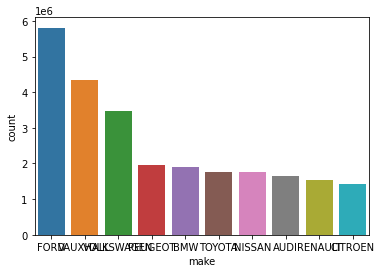

In [28]:
import seaborn as sns

sns.barplot(x=top10makes['make'],y=top10makes['count']);

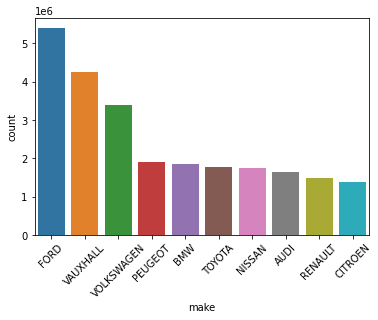

In [36]:
makesplot = sns.barplot(x=top10makes['make'],y=top10makes_c4['count']);
makesplot.set_xticklabels(makesplot.get_xticklabels(), rotation=45);